In [466]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: Set visualization style
sns.set_theme(style="whitegrid")

In [468]:
df = pd.read_csv('cybercrime_forensic_dataset.csv')

In [470]:
# Display basic information
print("First five rows of the dataset:")
print(df.head())

First five rows of the dataset:
                    Timestamp  User_ID       IP_Address      Activity_Type  \
0  2024-09-27 12:53:26.390859     9288     10.174.236.5  File_Modification   
1  2024-10-02 15:13:49.741543     1605   172.19.128.216         USB_Insert   
2  2024-09-13 14:31:39.163288     3056  192.168.201.132  File_Modification   
3  2024-10-02 22:27:57.622008     1564   10.119.122.121    Network_Traffic   
4  2024-10-01 08:00:55.017797     3660      172.23.2.38         USB_Insert   

                Resource_Accessed         File_Name  Action  Login_Attempts  \
0  /network/logs/new_project.docx  new_project.docx  Delete             NaN   
1             /server/secrets.txt               NaN    Read             NaN   
2         /project/document2.docx    document2.docx     NaN             NaN   
3          /backup/document2.docx               NaN  Delete             NaN   
4       /confidential/report1.pdf               NaN   Write             NaN   

   File_Size  Anomaly_Ty

In [472]:
print("\nDataset summary:")
print(df.info())


Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          7400 non-null   object 
 1   User_ID            7400 non-null   int64  
 2   IP_Address         7400 non-null   object 
 3   Activity_Type      7400 non-null   object 
 4   Resource_Accessed  7400 non-null   object 
 5   File_Name          3196 non-null   object 
 6   Action             6348 non-null   object 
 7   Login_Attempts     2105 non-null   float64
 8   File_Size          3196 non-null   float64
 9   Anomaly_Type       1233 non-null   object 
 10  Label              7400 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 636.1+ KB
None


In [474]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Timestamp               0
User_ID                 0
IP_Address              0
Activity_Type           0
Resource_Accessed       0
File_Name            4204
Action               1052
Login_Attempts       5295
File_Size            4204
Anomaly_Type         6167
Label                   0
dtype: int64


In [476]:
print("\nBasic statistics of numerical columns:")
print(df.describe())


Basic statistics of numerical columns:
           User_ID  Login_Attempts    File_Size
count  7400.000000     2105.000000  3196.000000
mean   5535.768378        5.428504    24.669703
std    2575.574425        2.862625    14.133492
min    1000.000000        1.000000     0.130000
25%    3358.750000        3.000000    12.635000
50%    5516.000000        5.000000    24.590000
75%    7755.000000        8.000000    36.782500
max    9997.000000       10.000000    49.980000


In [478]:
# Fill missing values with appropriate replacements
df['File_Name'] = df['File_Name'].fillna('Unknown')
df['File_Size'] = df['File_Size'].fillna(0)
df['Action'] = df['Action'].fillna('N/A')
df['Login_Attempts'] = df['Login_Attempts'].fillna(0)
df['Anomaly_Type'] = df['Anomaly_Type'].fillna('None')

In [480]:
# Verify missing values are handled
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Timestamp            0
User_ID              0
IP_Address           0
Activity_Type        0
Resource_Accessed    0
File_Name            0
Action               0
Login_Attempts       0
File_Size            0
Anomaly_Type         0
Label                0
dtype: int64


In [482]:
# 4. Feature Engineering
# Convert Timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract useful time-based features
df['Hour'] = df['Timestamp'].dt.hour  # Hour of the day
df['Day'] = df['Timestamp'].dt.day    # Day of the month
df['Month'] = df['Timestamp'].dt.month  # Month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)

# Calculate time difference between consecutive events for each user
df['Time_Diff'] = df.sort_values(by=['User_ID', 'Timestamp']) \
                     .groupby('User_ID')['Timestamp'] \
                     .diff().dt.total_seconds()

In [484]:
# Add IP frequency (how often each IP appears)
df['IP_Frequency'] = df.groupby('IP_Address')['IP_Address'].transform('count')

In [486]:
# Drop unnecessary columns
df = df.drop(columns=['User_ID', 'Timestamp'])  # Adjust as per your dataset


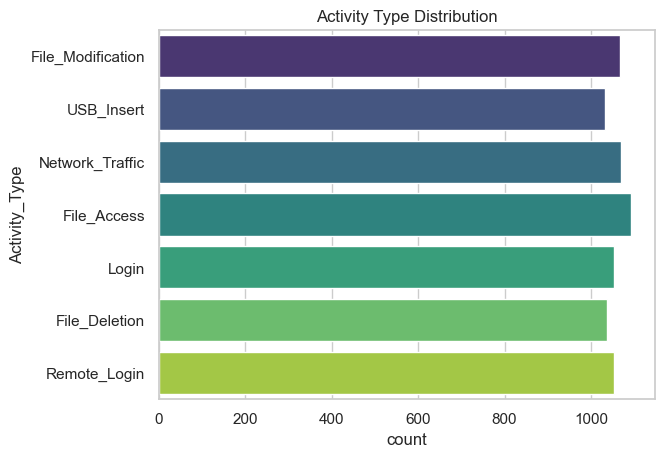

In [488]:
# Activity type distribution
sns.countplot(y='Activity_Type', data=df, palette='viridis', hue='Activity_Type', legend=False)
plt.title('Activity Type Distribution')
plt.show()

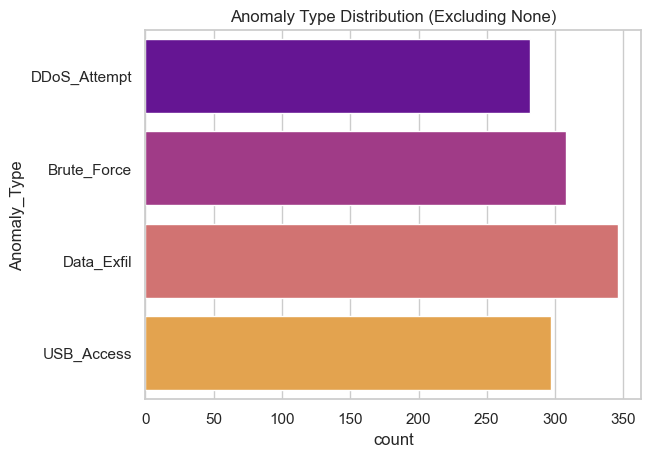

In [490]:
# Anomaly type distribution (excluding 'None')
sns.countplot(y='Anomaly_Type', 
              data=df[df['Anomaly_Type'] != 'None'], 
              palette='plasma', 
              hue='Anomaly_Type', 
              legend=False)
plt.title('Anomaly Type Distribution (Excluding None)')
plt.show()


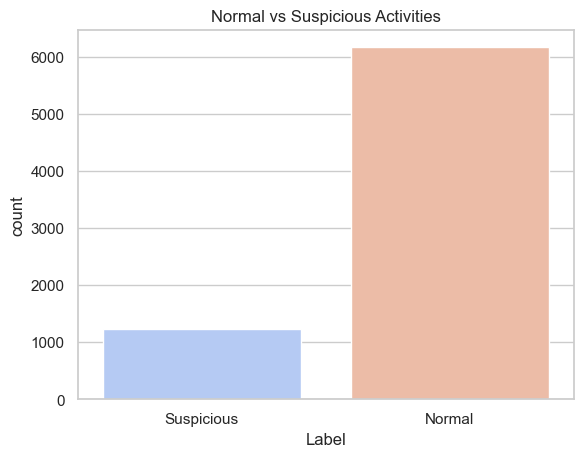

In [492]:
# Label distribution
sns.countplot(x='Label', data=df, palette='coolwarm', hue='Label', dodge=False, legend=False)
plt.title('Normal vs Suspicious Activities')
plt.show()

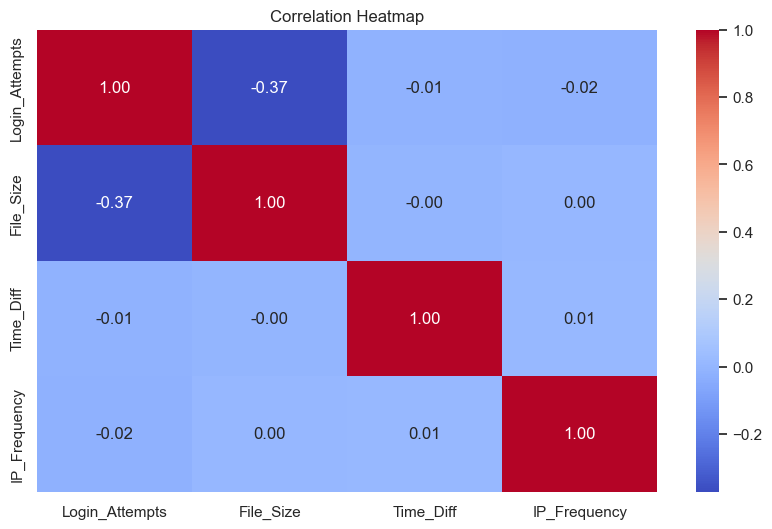

In [498]:
# Correlation heatmap for numerical columns
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [502]:
# 6. Label Encoding for categorical columns
le_ip = LabelEncoder()
le_file = LabelEncoder()

# Encode 'IP_Address' and 'File_Name' columns
df['IP_Address'] = le_ip.fit_transform(df['IP_Address'])
df['File_Name'] = le_file.fit_transform(df['File_Name'])

In [504]:
# 7. Train-Test Split
X = df.drop(columns='Label')  # Features
y = df['Label']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [506]:
# 8. Model Building
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [508]:
# 9. Model Evaluation
# Predictions
y_pred = rf_model.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Accuracy score
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1230
  Suspicious       1.00      1.00      1.00       250

    accuracy                           1.00      1480
   macro avg       1.00      1.00      1.00      1480
weighted avg       1.00      1.00      1.00      1480


Confusion Matrix:
[[1230    0]
 [   0  250]]

Accuracy Score:
1.0


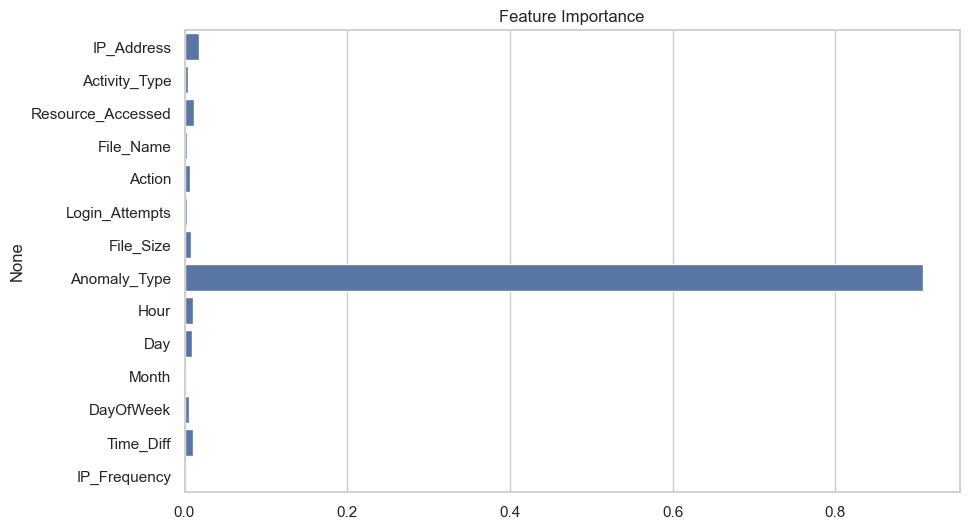

In [510]:
# 10. Feature Importance (Optional)
# Plotting feature importances
feature_importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.show()

In [512]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores and their mean
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation score: 1.0


In [516]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0


In [517]:
# Best parameters from Grid Search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Best model (RandomForestClassifier with optimal parameters)
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)

# Print evaluation metrics
print(f"Accuracy on the test set: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0
Accuracy on the test set: 1.0

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1230
  Suspicious       1.00      1.00      1.00       250

    accuracy                           1.00      1480
   macro avg       1.00      1.00      1.00      1480
weighted avg       1.00      1.00      1.00      1480


Confusion Matrix:
[[1230    0]
 [   0  250]]


In [522]:
# Assuming y_pred contains the predictions from the best model and df has the necessary columns
# Add the predictions to the dataframe
df['Predicted_Label'] = best_rf_model.predict(X)

# Filter out the rows where the label or prediction is "Suspicious"
suspicious_data = df[df['Predicted_Label'] == 'Suspicious']

# Alternatively, if you're working with the original Label column:
# suspicious_data = df[df['Label'] == 'Suspicious']

# Save the suspicious data to a new CSV file
suspicious_data.to_csv('suspicious_data.csv', index=False)

print("Suspicious data has been saved to 'suspicious_data.csv'")


Suspicious data has been saved to 'suspicious_data.csv'
